In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
train_dir = "../ForTrain"
valid_dir = "../ForValid"

# Updated Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,         # New - rotation augmentation
    horizontal_flip=True,      # New - horizontal flipping
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Smaller batch size for stability
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3000 images belonging to 15 classes.
Found 1494 images belonging to 15 classes.


In [56]:
class_dict = train_generator.class_indices
print(class_dict)

{'Rice_BrownSpot': 0, 'Rice_Healthy': 1, 'Rice_Hispa': 2, 'apple_black_rot': 3, 'apple_healthy': 4, 'apple_scab': 5, 'cherry_healthy': 6, 'cherry_powdery_mildew': 7, 'corn_(maize)_common_rust': 8, 'corn_(maize)_healthy': 9, 'corn_(maize)_northern_leaf_blight': 10, 'tomato_bacterial_spot': 11, 'tomato_early_blight': 12, 'tomato_healthy': 13, 'tomato_late_blight': 14}


In [57]:
li = list(class_dict.keys())
print(li)

['Rice_BrownSpot', 'Rice_Healthy', 'Rice_Hispa', 'apple_black_rot', 'apple_healthy', 'apple_scab', 'cherry_healthy', 'cherry_powdery_mildew', 'corn_(maize)_common_rust', 'corn_(maize)_healthy', 'corn_(maize)_northern_leaf_blight', 'tomato_bacterial_spot', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']


In [25]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [36]:
# Load the VGG16 model without the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False)

# Freeze the VGG16 base layers
vgg16_base.trainable = False

# Input layer (Functional API requires explicit input layer)
input_layer = Input(shape=(224, 224, 3))

# Pass the input through the VGG16 base model
x = vgg16_base(input_layer)

# Global Average Pooling to reduce to a single 2D vector
x = GlobalAveragePooling2D()(x)

# Add a Dense layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add Dropout layer to avoid overfitting
x = Dropout(0.5)(x)

# Output layer with 15 classes (softmax for classification)
output_layer = Dense(15, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

In [43]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,  # Validation steps
    epochs=10,  # Set the number of epochs
    verbose=1  # Display the training progress
)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.2301 - loss: 2.3435 - val_accuracy: 0.6318 - val_loss: 1.3303
Epoch 2/10
 1/93 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.5938 - loss: 1.2944

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5938 - loss: 1.2944 - val_accuracy: 0.6364 - val_loss: 1.3936
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.5521 - loss: 1.3452 - val_accuracy: 0.7194 - val_loss: 0.9173
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6562 - loss: 1.0588 - val_accuracy: 0.8182 - val_loss: 0.7662
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.6440 - loss: 1.0175 - val_accuracy: 0.7493 - val_loss: 0.7866
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5625 - loss: 1.0495 - val_accuracy: 0.8636 - val_loss: 0.5972
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.7093 - loss: 0.8473 - val_accuracy: 0.7785 - val_loss: 0.6691
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8750 - loss: 0.5377 - val_accuracy: 0.7273 - val_loss: 0.6588
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.7207 - loss: 0.7740 - val_accuracy: 0.7758 - val_loss: 0.

In [47]:
model.summary()
# print(model.shape)

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,525,743 (59.23 MB)

 Trainable params: 270,351 (1.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 540,704 (2.06 MB)

In [17]:
import pickle

In [48]:
#Saving our model
model.save("TrainedModel/TrainedTest5.keras")


In [19]:
from tensorflow.keras.models import load_model


In [49]:
# loaded_model = load_model("modelVGG16TRAIN.h5", custom_objects={"CustomLayer": CustomLayer})
loaded_model = load_model("c:/vgg16/TrainedModel/TrainedTest5.keras", custom_objects={})

In [61]:
# predicting an image
from keras.preprocessing import image
from matplotlib import pyplot as plt

Following is our prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


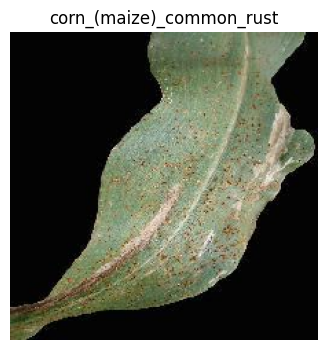

In [62]:
image_path = "C:/Users/ACER/Downloads/Plant_disease_dataset/test/test/CornCommonRust1.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()